<a href="https://colab.research.google.com/github/sravyagadam/ML_REGRESSION_CAPSTONE/blob/main/RetailSalesPrediction_ML_sravya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
store_data = pd.read_csv('/content/drive/MyDrive/RetailSalesPrediction_Sravya/Rossmann Stores Data.csv')
stores = pd.read_csv('/content/drive/MyDrive/RetailSalesPrediction_Sravya/store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
store_data.dropna(inplace=True)
stores.dropna(inplace=True)

In [5]:
store_data['Date']= pd.to_datetime(store_data['Date'])

In [6]:
store_data['Year'] = pd.DatetimeIndex(store_data['Date']).year
store_data['Month'] = pd.DatetimeIndex(store_data['Date']).month

In [7]:
store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7


In [8]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [9]:
## Wherever Promo2 ie continuing and consecutive promotion is zero, implies store didn't participate,
# hence Promo2SinceWeek and Promo2SinceYear should be zero, also there won't be PromoInterval
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceWeek'].isna()),['Promo2SinceWeek']]=0
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceYear'].isna()),['Promo2SinceYear','PromoInterval']]=0

In [10]:
stores.loc[stores['CompetitionDistance'].isna()]=stores['CompetitionDistance'].max()#CompetitionDistance

In [11]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    351
CompetitionOpenSinceYear     351
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [12]:
store_data['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [13]:
stores[stores['Promo2SinceYear']!=0]['Promo2SinceYear'].min()

2009.0

In [14]:
### Code Ref https://www.kaggle.com/shivam017arora/rossmann-sales-prediction-top-1-solution
## Modified accordingly

competition_open = []
for index, value in stores[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
    try:
        year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
        date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
        competition_open.append(date)
    except:
        competition_open.append('1813-01-01') # Added a dummy date, 200 yrs less than min sales date
stores['CompetitionOpen'] = pd.Series(competition_open)
stores['CompetitionOpen'] = stores['CompetitionOpen'].dt.strftime('%Y-%m-%d')
stores['CompetitionOpen']= pd.to_datetime(stores['CompetitionOpen'])





promo = []
for index, value in stores[['Promo2SinceWeek', 'Promo2SinceYear']].iterrows():
    try:
        year, week = int(value['Promo2SinceYear']), int(value['Promo2SinceWeek'])
        date = pd.to_datetime("{}{}0".format(year, week), format='%Y%W%w')
        promo.append(date)
    except:
        promo.append('1909-01-01')   ## dummy date
stores['promoYearWeek'] = pd.to_datetime(pd.Series(promo))
stores['promoYearWeek'] = stores['promoYearWeek'].dt.strftime('%Y%m%d')
stores['promoYearWeek']= pd.to_datetime(stores['promoYearWeek'])


In [15]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      1115 non-null   int64         
 1   StoreType                  1115 non-null   object        
 2   Assortment                 1115 non-null   object        
 3   CompetitionDistance        1115 non-null   float64       
 4   CompetitionOpenSinceMonth  764 non-null    float64       
 5   CompetitionOpenSinceYear   764 non-null    float64       
 6   Promo2                     1115 non-null   int64         
 7   Promo2SinceWeek            1115 non-null   float64       
 8   Promo2SinceYear            1115 non-null   float64       
 9   PromoInterval              1115 non-null   object        
 10  CompetitionOpen            1115 non-null   datetime64[ns]
 11  promoYearWeek              1115 non-null   datetime64[ns]
dtypes: dat

In [16]:
store_data_merged=pd.merge(store_data,stores,on='Store')

In [17]:
store_data_merged['day_diff_comp']=(store_data_merged['Date']-store_data_merged['CompetitionOpen']).dt.days
store_data_merged['day_diff_promo']=(store_data_merged['Date']-store_data_merged['promoYearWeek']).dt.days
store_data_merged.loc[store_data_merged['day_diff_comp']>=73000,'day_diff_comp']=0
store_data_merged.loc[store_data_merged['day_diff_promo']>=36500,'day_diff_promo']=0

In [18]:
store_data_merged.drop(columns=['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceWeek','Promo2SinceYear','PromoInterval','CompetitionOpen','promoYearWeek'],inplace=True)

In [19]:
store_data_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,c,a,1270.0,0,2524,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,7,c,a,1270.0,0,2523,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,7,c,a,1270.0,0,2522,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,7,c,a,1270.0,0,2521,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,7,c,a,1270.0,0,2520,0


In [20]:
store_data_merged['CompetitionDistance']=store_data_merged['CompetitionDistance'].astype(int)

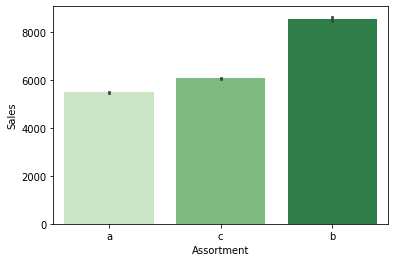

In [21]:
Assortment_Sales = sns.barplot(x='Assortment', y='Sales', data= store_data_merged, palette='Greens')
Assortment_Sales

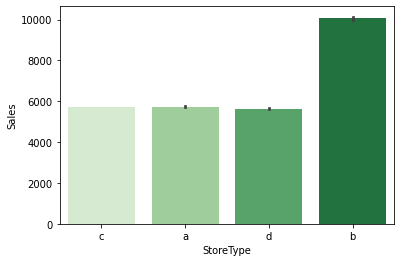

In [22]:
StoreType_sales = sns.barplot(x='StoreType', y='Sales', data= store_data_merged, palette='Greens')
StoreType_sales

In [23]:
store_data_merged['Assortment']=store_data_merged['Assortment'].apply(lambda x: 1 if x=='a' else (2 if x=='b' else 3))

In [24]:
store_data_final=pd.get_dummies(store_data_merged,drop_first=True)

In [25]:
store_data_final.isna().sum()


Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
SchoolHoliday          0
Year                   0
Month                  0
Assortment             0
CompetitionDistance    0
Promo2                 0
day_diff_comp          0
day_diff_promo         0
StateHoliday_0         0
StateHoliday_a         0
StateHoliday_b         0
StateHoliday_c         0
StoreType_b            0
StoreType_c            0
StoreType_d            0
dtype: int64

In [26]:
store_data_final.drop(columns=['Date'],inplace=True) ## Dropping Date column as month and year have been extracted

In [27]:
store_data_final.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d
0,1,5,5263,555,1,1,1,2015,7,1,1270,0,2524,0,1,0,0,0,0,1,0
1,1,4,5020,546,1,1,1,2015,7,1,1270,0,2523,0,1,0,0,0,0,1,0
2,1,3,4782,523,1,1,1,2015,7,1,1270,0,2522,0,1,0,0,0,0,1,0
3,1,2,5011,560,1,1,1,2015,7,1,1270,0,2521,0,1,0,0,0,0,1,0
4,1,1,6102,612,1,1,1,2015,7,1,1270,0,2520,0,1,0,0,0,0,1,0


In [28]:
store_data_final = store_data_final[store_data_final.Open != 0]

#Selecting the columns for Training
'Store', 'DayOfWeek',  'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2',
       'Promo2SinceYear', 'PromoInterval',
       'Promo2Open', 'IsPromo2Month'



In [30]:
dependent_variable = 'Sales'

In [33]:
independent_variables = ['Customers', 'DayOfWeek', 'Open',
       'Promo', 'SchoolHoliday', 'Year',
       'Month', 'Assortment', 'CompetitionDistance','Promo2',
       'day_diff_comp','day_diff_promo','StateHoliday_0','StateHoliday_a','StateHoliday_b',
       'StateHoliday_c','StoreType_b','StoreType_c','StoreType_d']

##Adding dependent variables and independent variables 

In [35]:
X = store_data_final[independent_variables]
y = store_data_final[dependent_variable]

##Splitting the data into test and train data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

##Calculating entropy and Visualizing Decision tree

In [38]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

## Calculating /predicting using entropy 

In [2]:
sales_prediction = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=10, random_state=0)
sales_prediction.fit(X_train, y_train)

NameError: ignored

In [1]:
y_predicted = sales_prediction.predict(X_test)

NameError: ignored

In [ ]:
graph = Source(tree.export_graphviz(humidity_classifier, out_file=None
   , feature_names=X_train.columns, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))